# 1. Acquire

In [1]:
# Import Python Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Acquire and Prep Files
import Acquire
import os 
import Prepare 

# Import for model object and metric functions
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from scipy import stats
from math import sqrt

# Import Warnings 
import warnings
warnings.filterwarnings("ignore")

print('Imports Completed.')

Imports Completed.


In [2]:
df = Acquire.get_mvp_home_data() 

In [3]:
df.head()

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
0,1018,1819.0,3.0,2.0,478430.0
1,1248,1000.0,0.0,0.0,27400.0
2,1734,1503.0,2.0,2.0,171687.0
3,1772,1604.0,4.0,2.0,498347.0
4,2028,2384.0,3.0,3.0,549917.0


# 2. Prepare

In [4]:
df.shape

(19149, 5)

In [5]:
df.describe() 

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt
count,19149.000000,18783.000000,19149.000000,19149.000000,1.884100e+04
mean,52465.910805,1784.874621,3.006632,2.205833,4.443516e+05
std,6396.665259,965.575765,1.148385,1.035924,5.547795e+05
min,1018.000000,60.000000,0.000000,0.000000,1.000000e+01
25%,47163.000000,1204.000000,2.000000,2.000000,1.925360e+05
50%,52742.000000,1557.000000,3.000000,2.000000,3.294930e+05
75%,57785.000000,2102.500000,4.000000,3.000000,5.280000e+05
max,62970.000000,26345.000000,10.000000,19.500000,1.717000e+07


In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19149 entries, 0 to 19148
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            19149 non-null  int64  
 1   calculatedfinishedsquarefeet  18783 non-null  float64
 2   bedroomcnt                    19149 non-null  float64
 3   bathroomcnt                   19149 non-null  float64
 4   taxvaluedollarcnt             18841 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 897.6 KB


In [7]:
df.isnull().sum() 

id                                0
calculatedfinishedsquarefeet    366
bedroomcnt                        0
bathroomcnt                       0
taxvaluedollarcnt               308
dtype: int64

In [8]:
# Dropping null values
df = df.dropna()

In [9]:
df.isnull().sum() 

id                              0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
bathroomcnt                     0
taxvaluedollarcnt               0
dtype: int64

In [10]:
# Renaming columns
df = df.rename(columns = {'calculatedfinishedsquarefeet':'sqft'})
df = df.rename(columns = {'bedroomcnt':'bedroom_count'})
df = df.rename(columns = {'bathroomcnt':'bathroom_count'})
df = df.rename(columns = {'taxvaluedollarcnt':'tax_value'})

In [11]:
# Drop id column
df = df.drop(columns='id')
df.head()

,sqft,bedroom_count,bathroom_count,tax_value
0,1819.0,3.0,2.0,478430.0
1,1000.0,0.0,0.0,27400.0
2,1503.0,2.0,2.0,171687.0
3,1604.0,4.0,2.0,498347.0
4,2384.0,3.0,3.0,549917.0


# Additional features

In [12]:
import env

def get_connection(db, username=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{username}:{password}@{host}/{db}'

sql_test = '''SELECT prop.id, calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, fullbathcnt, yearbuilt, regionidzip, heatingorsystemtypeid, taxvaluedollarcnt, taxamount, buildingqualitytypeid, regionidcity
FROM properties_2017 as prop
JOIN propertylandusetype as land ON prop.propertylandusetypeid = land.propertylandusetypeid
JOIN predictions_2017 as pred ON pred.id = prop.id 
AND (pred.transactiondate LIKE '2017-05-%%'
OR pred.transactiondate LIKE '2017-06-%%')
WHERE prop.propertylandusetypeid IN (260, 261, 263, 264, 266, 279);'''
    
df = pd.read_sql(sql_test, get_connection('zillow'))

df.head()

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,fullbathcnt,yearbuilt,regionidzip,heatingorsystemtypeid,taxvaluedollarcnt,taxamount,buildingqualitytypeid,regionidcity
0,1248,1000.0,0.0,0.0,NaN,2002.0,97083.0,NaN,27400.0,212.46,NaN,34543.0
1,1772,1604.0,4.0,2.0,2.0,1950.0,96415.0,7.0,498347.0,6089.82,6.0,12447.0
2,2028,2384.0,3.0,3.0,3.0,1937.0,96452.0,2.0,549917.0,6679.55,8.0,12447.0
3,3273,1574.0,3.0,2.0,2.0,1990.0,97319.0,2.0,235272.0,3876.31,8.0,5534.0
4,3429,1619.0,2.0,2.0,2.0,1983.0,97329.0,2.0,340000.0,4206.15,6.0,40227.0


In [13]:
df.describe()

,id,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,fullbathcnt,yearbuilt,regionidzip,heatingorsystemtypeid,taxvaluedollarcnt,taxamount,buildingqualitytypeid,regionidcity
count,19683.000000,19510.000000,19683.000000,19683.000000,19296.000000,19506.000000,19642.000000,14808.000000,1.953400e+04,19604.000000,14724.000000,19359.000000
mean,42440.900015,1740.763762,3.023370,2.176269,2.178275,1962.602943,96497.998473,4.009049,4.455571e+05,5433.700772,6.366612,36087.266646
std,6405.282175,944.118081,1.074486,1.023668,0.973149,23.024485,3767.574247,2.935759,6.171164e+05,7173.276288,1.715384,55069.212984
min,1248.000000,60.000000,0.000000,0.000000,1.000000,1862.000000,95982.000000,2.000000,1.900000e+01,10.100000,1.000000,3491.000000
25%,37205.500000,1176.000000,2.000000,2.000000,2.000000,1949.000000,96152.000000,2.000000,1.814800e+05,2428.667500,5.000000,12447.000000
50%,42445.000000,1517.000000,3.000000,2.000000,2.000000,1960.000000,96341.000000,2.000000,3.120655e+05,3927.025000,6.000000,24832.000000
75%,47783.500000,2032.000000,4.000000,3.000000,3.000000,1979.000000,96941.000000,7.000000,5.104338e+05,6144.365000,8.000000,46080.000000
max,53503.000000,26345.000000,25.000000,20.000000,20.000000,2015.000000,399675.000000,24.000000,1.912982e+07,228999.210000,12.000000,396556.000000


In [14]:
df.dtypes

id                                int64
calculatedfinishedsquarefeet    float64
bedroomcnt                      float64
bathroomcnt                     float64
fullbathcnt                     float64
yearbuilt                       float64
regionidzip                     float64
heatingorsystemtypeid           float64
taxvaluedollarcnt               float64
taxamount                       float64
buildingqualitytypeid           float64
regionidcity                    float64
dtype: object

In [15]:
df.shape

(19683, 12)

In [16]:
df.isnull().sum()

id                                 0
calculatedfinishedsquarefeet     173
bedroomcnt                         0
bathroomcnt                        0
fullbathcnt                      387
yearbuilt                        177
regionidzip                       41
heatingorsystemtypeid           4875
taxvaluedollarcnt                149
taxamount                         79
buildingqualitytypeid           4959
regionidcity                     324
dtype: int64

In [17]:
df = df.dropna()

In [18]:
df.isnull().sum()

id                              0
calculatedfinishedsquarefeet    0
bedroomcnt                      0
bathroomcnt                     0
fullbathcnt                     0
yearbuilt                       0
regionidzip                     0
heatingorsystemtypeid           0
taxvaluedollarcnt               0
taxamount                       0
buildingqualitytypeid           0
regionidcity                    0
dtype: int64

In [19]:
df.shape

(14233, 12)

In [20]:
df = df.rename(columns = {'calculatedfinishedsquarefeet':'sqft'})
df = df.rename(columns = {'bedroomcnt':'bedroom_count'})
df = df.rename(columns = {'bathroomcnt':'bathroom_count'})
df = df.rename(columns = {'taxvaluedollarcnt':'tax_value'})
df = df.rename(columns = {'regionidzip':'zip'})
df = df.rename(columns = {'heatingorsystemtypeid':'heating'})

df = df.drop(columns='id')

In [21]:
df.head()

,sqft,bedroom_count,bathroom_count,fullbathcnt,yearbuilt,zip,heating,tax_value,taxamount,buildingqualitytypeid,regionidcity
1,1604.0,4.0,2.0,2.0,1950.0,96415.0,7.0,498347.0,6089.82,6.0,12447.0
2,2384.0,3.0,3.0,3.0,1937.0,96452.0,2.0,549917.0,6679.55,8.0,12447.0
3,1574.0,3.0,2.0,2.0,1990.0,97319.0,2.0,235272.0,3876.31,8.0,5534.0
4,1619.0,2.0,2.0,2.0,1983.0,97329.0,2.0,340000.0,4206.15,6.0,40227.0
5,1936.0,3.0,3.0,3.0,1986.0,96124.0,2.0,418146.0,5278.74,8.0,33612.0


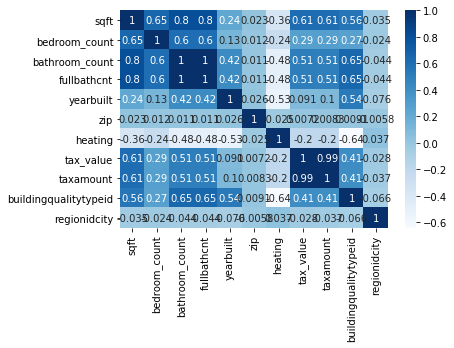

In [22]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

<b>Takeaways: </b>
- There are some definite outliers in the dataset on the low end of square feet and tax value
- Still not sure whether 0 bedroom/ 0 bathroom is refering to a studio apartment or some other situation
- The features with the highest correlation with tax_value are (listed in order from highest to lowest):
    - sqft
    - bathroom_count
    - fullbathcnt
    - bedroom_count
    - buildingqualitytypeid

# 3. Explore

### Continuous and Continuous Variables  

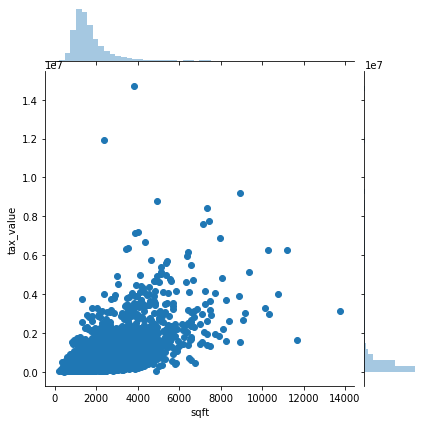

In [23]:
sns.jointplot(x= 'sqft', y='tax_value', data=df)

In [ ]:
sns.pairplot(df, corner=True) 

In [ ]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

### Continuous and Categorical Variables

In [ ]:
df.bedroom_count.value_counts().sort_index().plot.bar(title='Bedroom Count Distribution')
plt.xlabel('# of Bedrooms')
plt.ylabel('# of Units')
plt.xticks(rotation=0) 

In [ ]:
df.bathroom_count.value_counts().sort_index().plot.bar(title='Bathroom Count Distribution')
plt.xlabel('# of Bathrooms')
plt.ylabel('# of Units') 
plt.xticks(rotation=0) 

### Categorical and Categorical Variables

In [ ]:
sns.barplot(data=df, x='bedroom_count', y='bathroom_count')
plt.ylim(0,25) 

In [ ]:
pd.crosstab(df.bedroom_count, df.bathroom_count, normalize='index') 

<b>Takeaways: </b>
- Most homes have 3 bedrooms/ 2 baths

### Train, Validate, and Test

In [ ]:
# split into train, validate, and test sets
train_and_validate, test = train_test_split(df, random_state=123)
train, validate = train_test_split(train_and_validate, random_state=123)

In [ ]:
# Split into X and y
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]

# Validate split
X_validate = validate.drop(columns='tax_value')
y_validate = validate[['tax_value']]

# Test split
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

### Scale Data

In [ ]:
# 1. Create the Scaling Object
scaler = sklearn.preprocessing.StandardScaler()

# 2. Fit to the train data only
scaler.fit(train.drop('tax_value', axis=1))

# 3. use the object on the whole df
# this returns an array, so we convert to df in the same line
train_scaled = pd.DataFrame(scaler.transform(train.drop('tax_value', axis=1)))
validate_scaled = pd.DataFrame(scaler.transform(validate.drop('tax_value', axis=1)))
test_scaled = pd.DataFrame(scaler.transform(test.drop('tax_value', axis=1)))

In [ ]:
# Train
train_scaled.index = train.index
train_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
train = pd.concat((train, train_scaled), axis=1)

# Validate
validate_scaled.index = validate.index
validate_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
validate = pd.concat((validate, validate_scaled), axis=1)

# Test
test_scaled.index = test.index
test_scaled.columns = ['bath_count_scaled','bed_count_scaled','square_feet_scaled']
test = pd.concat((test, test_scaled), axis=1)

### Run Tests

- T-test 
- Correlation test

In [ ]:
train.head()

### T-test

$H0$: The average price of homes with 5000 sq.ft. or more is equal to the average price of homes with 5000 sq.ft. or less.  
$H1$: Homes with 5000 sq.ft. or more have higher than average tax dollar count.

In [ ]:
train.sqft.mean()

In [ ]:
df_less_than_5000 = train[train.sqft >= 5000]
df_greater_than_5000 = train[train.sqft > 5000]

In [ ]:
a = df_less_than_5000.tax_value.mean()

b = df_greater_than_5000.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_5000.tax_value,
                df_less_than_5000.tax_value)

if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

$H0$: Average price of homes with more than two bathrooms is equal to the average price of homes with less than two bathrooms.    
$H1$: Homes with more than two bathrooms have higher than average tax dollar count.

In [ ]:
train.bathroom_count.mean()

In [ ]:
df_less_than_2_bath = train[train.bathroom_count >= 2]
df_greater_than_2_bath = train[train.bathroom_count > 2]

In [ ]:
a = df_less_than_2_bath.tax_value.mean()

b = df_greater_than_2_bath.tax_value.mean()

t, p = stats.ttest_ind(df_greater_than_2_bath.tax_value,
                df_less_than_2_bath.tax_value)

if p > a:
    print('We Fail to Reject H0')
else:
    print('We Reject H0')

### Correlation Test

$H0$: There is no relationship between total house square feet and tax value   
$H1$: There is a relationship between total house square feet and tax value

In [ ]:
confidence_interval = 0.95
alpha = 1 - confidence_interval 
t, p = stats.pearsonr(X_train.sqft, y_train.tax_value)

corr, p = stats.pearsonr(train['sqft'], train['tax_value'])
print(corr, p)

if p > alpha:
    print('We Fail to Reject H0')
else:
    print('We Reject H0a')

# 4. Model

- Develop a regression model that performs better than a baseline 
- Extablish a baseline model
- Document various algorithms and/or hyperparameters
- Plot the residuals
- Compute the evaluation metrics (SSE, RMSE, and/or MSE)
- Compare to baseline
- Plot y by ^y
- Create a model.py file

### Baseline Model

# 5. Conclusions